# CAMERA Workshop 2019

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Image processing for microCT using scikit-image (Part II)_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite software](preparation.md) beforehand.

For more info:
  * [[CAMERA Workshop 2019]](http://microct.lbl.gov/cameratomo2019/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from skimage import io

In [3]:
input_filename="../data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

In [ ]:
# uncomment if using Google colaboratory
#!wget https://github.com/dani-lbnl/imagexd19/blob/master/dip/data/bead_pack.tif?raw=true

In [ ]:
#!mv bead_pack.tif?raw=true bead_pack.tif

In [ ]:
#!ls *.tif

In [ ]:
#img = io.imread('bead_pack.tif')

## Basic image summary

In [4]:
print('* Shape: '+str(img.shape))
print('* Type: ' +str(img.dtype))
print('* Range: '+str(img.min())+','+ str(img.max()))

* Shape: (200, 200, 200)
* Type: uint8
* Range: 29,239


## Skim through

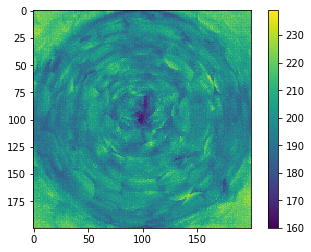

In [20]:
# Max projection is a fast way to pick on your stack content globally
x,_,_ = img.shape
IM_MAX = img[0,:,:]
for n in np.arange(1,x):
    IM_MAX = np.maximum(IM_MAX, img[n,:,:])
plt.imshow(IM_MAX)    
plt.colorbar()

In [7]:
#View each slice of original stack

from ipywidgets import interact,IntSlider

downsample = 1 #change to larger number if image shape > 1k 

def slicer(z):
    plt.imshow(img[z,::downsample,::downsample], cmap='gray')

interact(slicer, z=IntSlider(min=0, max=len(img), step=1, value=len(img)//2));

interactive(children=(IntSlider(value=100, description='z', max=200), Output()), _dom_classes=('widget-interac…

We will use the function slicer several times, so then let's create a way to quickly call it:

In [8]:
def slicing(b,lut='viridis'):
    def slicer(z):
        plt.imshow(b[z,:,:],cmap=lut, vmin=np.min(b), vmax=np.max(b)) #without vmin/vmax = dynamic :(
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));

## Exercise: non-uniform background
- calculate the mean projection of the stack
- plot a downsampled mean projection with 1/3 total number of pixels

In [29]:
# %load solutions/ex01.py

In [30]:
# %load solutions/ex02.py

## Is the intensity distribution bimodal? 

In [31]:
from skimage.util import img_as_ubyte
from skimage import data
from skimage.exposure import histogram


def seeHistSlice(img,nslice):
    noisy_image = img_as_ubyte(img[nslice,:,:])
    hist, hist_centers = histogram(noisy_image)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    ax[0].imshow(noisy_image, cmap=plt.cm.gray, vmin=0, vmax=np.max(img))
    ax[0].set_title('Slice at the middle of the stack')
    ax[0].axis('off')

    ax[1].plot(hist_centers, hist, lw=2)
    ax[1].set_title('Histogram of grey values')
    ax[1].grid()

    plt.tight_layout()
    

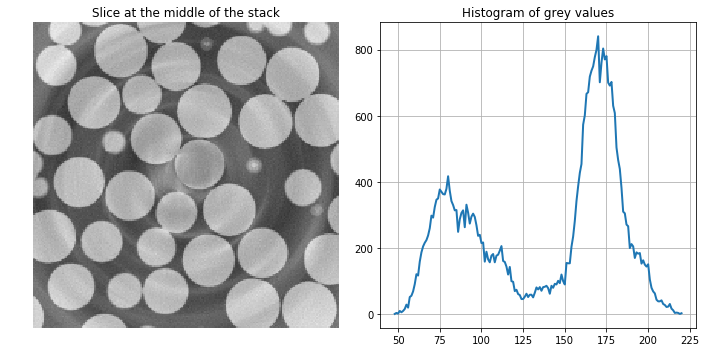

In [32]:
#Change nslice
nslice = len(img)//2 
seeHistSlice(img,nslice)

Now let's put a scroll bar to visualize stack

In [ ]:
def slicingHist(b):
    def slicer(z):
        seeHistSlice(b,z)
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));    

In [ ]:
slicingHist(img)

## Adjust exposure
- skimage.exposure.cumulative_distribution(image) 
- skimage.exposure.equalize(*args, **kwargs) 
- skimage.exposure.equalize_adapthist(image[, ...]) 
- skimage.exposure.equalize_hist(image[, nbins]) 
- skimage.exposure.histogram(image[, nbins]) 
- skimage.exposure.rescale_intensity(image[, ...]) 

In [ ]:
#Equalization for volume data, although you might be skiming through your data 
from skimage import exposure
a = exposure.equalize_hist(img)
slicing(a,'gray')

The Laplace operator or Laplacian is a differential operator given by the divergence of the gradient of a function on Euclidean space. In a Cartesian coordinate system, the Laplacian is given by the sum of second partial derivatives of the function with respect to each independent variable.

In [ ]:
#Find the edges of an image using Laplacian
from skimage import filters as fi
img2 = fi.laplace(img)
slicing(img2,'gray')

## Exercise: use other filters
- Explore [[skimage.filters.rank]](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html?highlight=rank#module-skimage.filters.rank) and apply to the 3D stack (suggestion: mean_bilateral, enhance_contrast)

In [ ]:
# %load solutions/ex03.py
from skimage.filters.rank import mean_bilateral
from skimage.morphology import disk

bilat = np.empty_like(img)
for i, aslice in enumerate(img):
    bilat[i] = mean_bilateral(aslice.astype(np.uint8), disk(3), s0=15, s1=15)

slicing(img,'gray')    


In [ ]:
# %load solutions/ex04.py
from skimage.filters.rank import enhance_contrast

contr = np.empty_like(img)
for i, aslice in enumerate(img):
    contr[i]= enhance_contrast(aslice.astype(np.uint16),disk(3))
slicing(contr,'gray')


# Scipy ndimage
- Multi-dimensional image processing/analysis: filters, interpolation, measurements
- https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [ ]:
#Let's run a median filter on our stack
from scipy import ndimage as ndi
from skimage.morphology import ball

aball = ball(radius=2) #3D structure element
median = ndi.median_filter(img,footprint=aball) 

In [ ]:
slicing(median,'gray')

# Exercise
- Transform raw image into a morphologically dilated one, using grayscale dilation 

In [ ]:
%load solutions/ex05.py

# Segmentation

In [ ]:
# checking the middle of the stack
n=len(img)//2 #middle
print("See slice: " + str(n))
aslice = median[n,:,:]
fi.try_all_threshold(aslice, figsize=(16,10), verbose=False)
#warning: box-forced is removed in Matplotlib 3.1

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:
fig.savefig("thresholdAll.png")

In [ ]:
# back to the full tack
t=fi.threshold_isodata(bilat)
binary = bilat>t

slicing(binary,'gray')

In [ ]:
def slicingMask(orig,binary):
    def slicer(z):
        plt.imshow(orig[z,:,:]*binary[z,:,:],cmap='gray',vmin=0, vmax=np.max(orig))
    interact(slicer, z=IntSlider(min=0,max=len(orig)-1,step=1,value=len(orig)//2));    

In [ ]:
# masking
slicingMask(img,binary)

## Exercises:
- Create a labeled stack and output the number of connected components
- Slide between slice 68 and 69: how to fix it??
- Create a function that returns the largest connected component from a stack

In [ ]:
from skimage.measure import label
labeled = label(binary.astype('int'),connectivity=2)
print(np.max(labeled))

In [ ]:
slicing(labeled,'rainbow')

In [ ]:
# %load solutions/02_solution01_c.py

def getLargestCC(segments):
        '''Return a mask corresponding to the largest object'''
        labels = label(segments.astype('int'),connectivity=1)
        largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segments.flat))
        return largestCC

a=getLargestCC(binary)

print('Volume largest obj: '+str(np.count_nonzero(a)))
print('Volume dense phase: '+str(np.count_nonzero(binary)))


# Clean up binary representation 

In [ ]:
from skimage import morphology
aball = morphology.ball(radius=5) #aggressive

In [ ]:
#3D Mathematical morphology
bin_e=morphology.binary_erosion(binary,selem=aball)
bin_o=morphology.binary_opening(binary,selem=aball)

In [ ]:
#show two 2D images side by side for quick comparison
def imshowcmp(before,after,lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

In [ ]:
imshowcmp(bin_e[n,:,:],bin_o[n,:,:],'gray')

In [ ]:
binary=bin_e

In [ ]:
labeled = label(binary.astype('int'),connectivity=2)
print(np.max(labeled))

slicing(labeled,'rainbow')
#do not fully trust what you see here

## Remove small objects

In [ ]:
cleaned = morphology.remove_small_objects(binary, min_size=5000, connectivity=1, in_place=False)

labeled = label(cleaned,connectivity=2)
print(np.max(labeled))


## Fill holes

In [ ]:
cleaned = morphology.remove_small_holes(cleaned, area_threshold=100, connectivity=1, in_place=True)
labeled = label(cleaned,connectivity=2)
nobjects = np.max(labeled)
print('Estimated number of objects in the stack:'+str(nobjects))

In [ ]:
slicing(labeled,'rainbow')

In [ ]:
# How to get a single object using labeled data?

loc = ndi.find_objects(labeled==50)[0]
bead = binary[loc]
bead.shape
np.sum(bead) #area

## Exercise:
- Create a graph where x=label number and y=volume of bead in pels
- Estimate the number of beads

In [ ]:
allBeads = ndi.find_objects(labeled)
accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)

In [ ]:
from skimage import segmentation
cleaned = segmentation.clear_border(cleaned)
labeled = label( cleaned )
allBeads = ndi.find_objects(labeled)
nobjects = np.max(labeled)
accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)
plt.title('Median Volume on Eroded stack='+str(np.median(accum)))

In [ ]:
print('Estimated number of objects in the stack: '+str(np.sum(cleaned) / 8816))

# Visualizing stacks with itkwidgets
- Visualize 2D and 3D images, point sets, and geometry, e.g. meshes, in Jupyter
- Support for NumPy array images, itk.Image, Dask array images and more
- More info at [[repo]](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [ ]:
#Tip: slide right to see different labeled object
import itk
from itkwidgets import view

#original img
image_itk = itk.GetImageFromArray(img.astype('uint8'))
#view(image_itk, slicing_planes=True, gradient_opacity=0)

In [ ]:
#cleaned
image_itk = itk.GetImageFromArray(labeled.astype('uint8'))
#view(image_itk, gradient_opacity=0, cmap = 'hsv')

In [ ]:
#a bead
#view(itk.GetImageFromArray(bead.astype('uint8')))

## Downsample for images > 1M voxels

In [ ]:
#Quick view of content
downsample = 3 #isotropic downsampling
image_np = cleaned[::downsample,::downsample,::downsample]
image_itk = itk.GetImageFromArray(image_np.astype('uint8'))
#view(image_itk, gradient_opacity=0.2,shadow=False)

## Anisotropic volumes

In [ ]:
new_spacing = [4, 1, 1]
image_itk.SetSpacing(new_spacing)
#view(image_itk, cmap='Blues', gradient_opacity=0.4)

In general, there's some much one can segment using only classical filters and thresholding. A complete investigation will often include machine learning methods using unsupervised and supervised classification of voxels.

## Euclidean distance transform

In [ ]:
from scipy import ndimage as ndi
edt = ndi.distance_transform_edt(cleaned)

In [ ]:
#view(itk.GetImageFromArray(edt.astype('uint8')),shadow=False,cmap='jet')

## Creating markers

In [ ]:
from skimage import feature
seeds = feature.peak_local_max(edt, indices = False, footprint=np.ones((3, 3, 3)),
                            labels=labeled) #return sparse matrix instead of array with peaks

In [ ]:
markers = label(seeds)
labeled_edt = morphology.watershed(-edt, markers, mask=cleaned)
print('Estimated number of objects in the stack: '+str(np.max(labeled_edt)))

In [ ]:
slicing(labeled_edt,'rainbow')

In [ ]:
import itk
from itkwidgets import view

image_itk = itk.GetImageFromArray(labeled_edt.astype(np.uint8))
#view(image_itk, cmap='Cold and Hot', rotate=True, gradient_opacity=0.4)

# Image segmentation:
- beyond thresholding: supervised and unsupervised machine learning
- skimage [segmentation](https://scikit-image.org/docs/dev/api/skimage.segmentation.html)
- sklearn [segmentation](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering)

## Supervised classification using markers

In [ ]:
from skimage import segmentation as seg
b = bilat[n,:,:]
plt.imshow(b)
plt.grid()

In [ ]:
#2D version
markers = (25, 30)  # Experiment with other markers
c = seg.flood(b, markers, tolerance=40)
plt.imshow(c)

In [ ]:
#3D version
markers = (n, 25, 30)  # Experiment with other markers
c = seg.flood(bilat, markers, tolerance=40)

In [ ]:
c = morphology.binary_dilation(c,selem=aball)
c = morphology.remove_small_objects(255-c, min_size=5000, connectivity=1, in_place=False)
slicing(c)

In [ ]:
print('Estimated number of objects in the stack: '+str(np.max(label(c))))

## Unsupervised - kmeans

In [ ]:
from skimage.segmentation import slic, mark_boundaries
from skimage import restoration
segments = slic(b, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=500, multichannel=False) #higher compact = more weight space, more square
plt.imshow(mark_boundaries(b, segments))

In [ ]:
from skimage import color
from skimage.future import graph
output = color.label2rgb(segments, aslice, kind='avg')
plt.imshow(output,cmap='gray')

The routine below can take several minutes depending on your computer configuration

In [ ]:
segments = slic(bilat, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=50, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, bilat, kind='avg')

In [ ]:
slicing(output)

In [ ]:
from skimage import img_as_ubyte
o = img_as_ubyte(output)
#view(o, slicing_planes=True,gradient_opacity=0.4)

# Measuring

In [ ]:
from skimage import feature, measure

In [ ]:
label = measure.label(cleaned)
regions = measure.regionprops(label,intensity_image=img)

In [ ]:
np.max(labeled) #len(regionprops)

In [ ]:
accum2 = [p.area for p in regions]

In [ ]:
plt.plot(accum2)

In [ ]:
area=accum2
convex_area = [p.convex_area for p in regions]
solidity = [p.solidity for p in regions]

In [ ]:
type(area)

In [ ]:
import pandas as pd
beadpd = pd.DataFrame(data = list(zip(area,convex_area,solidity)),
             columns = ['area','convex_area','solidity']
            )

In [ ]:
beadpd.to_csv('measurements.csv')

In [ ]:
#measurements = measure.regionprops_table(labeled,img,properties=['area','convex_area','solidity'])

In [ ]:
import skimage
skimage.__version__

In [ ]:
image_itk = itk.GetImageFromArray(label.astype(np.uint16))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)